# Prediction of Appointment No Show
Patients make appointments at clinics or hospitals to be checked by a doctor. Some of the patients do not show up for their appointments. This results in loss of valuable resources in terms of physician time and staffing allocation which could have been used more productively. we will prediction if the person shows up or not using a few classitfication algorithms.

In [3]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model, neighbors, ensemble
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix ,accuracy_score , plot_confusion_matrix ,plot_roc_curve
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import GradientBoostingClassifier 

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [4]:
df_appointments = pd.read_csv('appointment.csv')
df_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
X = df_appointments.drop(['Neighbourhood','Gender','ScheduledDay','AppointmentDay','Age','No-show'], axis = 1)
y = df_appointments['No-show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)
X_train, X_val , y_train, y_val = train_test_split(X_train ,y_train , test_size = 0.10, random_state=42)

lm = LogisticRegression()
lm.fit(X_train,y_train)

LogisticRegression()

In [6]:
lm.score (X_train,y_train)

0.7980586645220383

In [7]:
lm.score (X_test,y_test)

0.7986971862842667

# EDA Feature Engineering

In [8]:
min(df_appointments['Age'])

-1

In [9]:
df_appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [10]:
l=[]
for i in range(len(df_appointments['Age'])):
    if(df_appointments['Age'][i]<0):
        l.append(i)

In [11]:
df_appointments['Age'][99832]=1

<ipython-input-11-b47c06aaa696>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appointments['Age'][99832]=1


In [12]:
df_appointments['Scheduled_Day']=df_appointments['ScheduledDay'].str.extract('(\d\d)?T').astype(int)
df_appointments['Scheduled_Month']=df_appointments['ScheduledDay'].str.extract('(\d\d)?-..T').astype(int)

In [13]:
df_appointments['Weekday']=df_appointments['ScheduledDay'].str.extract('(\d\d\d\d-\d\d-\d\d)?T')

In [14]:
for i in range(len(df_appointments['Weekday'])):
    df_appointments['Weekday'][i]=pd.Timestamp(df_appointments['Weekday'][i]).dayofweek

<ipython-input-14-827a15eae874>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appointments['Weekday'][i]=pd.Timestamp(df_appointments['Weekday'][i]).dayofweek


In [15]:
UniqueValues = df_appointments. nunique()

<AxesSubplot:>

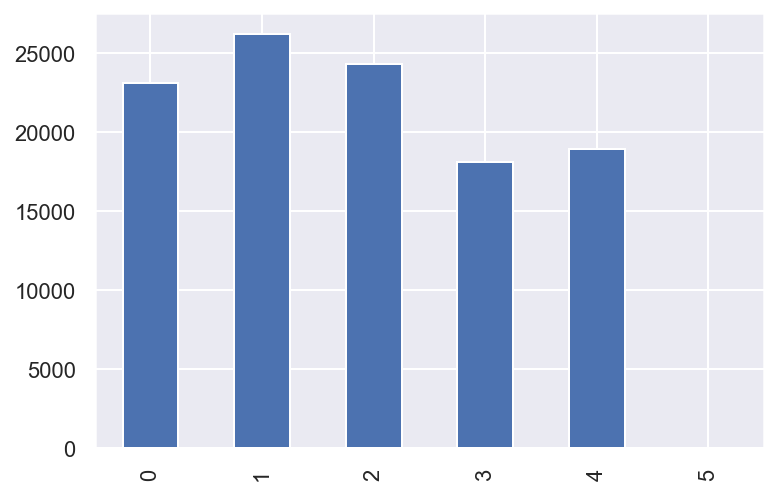

In [16]:
df_appointments['Weekday'].value_counts().sort_index().plot.bar()

In [17]:
df_appointments['No-show'] = df_appointments['No-show'].str.replace('No', '1')
df_appointments['No-show'] = df_appointments['No-show'].str.replace('Yes', '0')

df_appointments['Gender'] = df_appointments['Gender'].str.replace('M', '1')
df_appointments['Gender'] = df_appointments['Gender'].str.replace('F', '0')

In [18]:
df_appointments['Gender']=df_appointments['Gender'].astype('int') 
df_appointments['No-show']= df_appointments['No-show'].astype('int')
df_appointments['Weekday']= df_appointments['Weekday'].astype('int')

In [19]:
def zero_one(data, column):

    data[column].replace({data[column].unique()[0]:0, data[column].unique()[1]:1}, inplace=True)
    


# Changing NoShow and Gender values to zeros and ones 
zero_one(df_appointments, 'No-show')
zero_one(df_appointments, 'Gender')

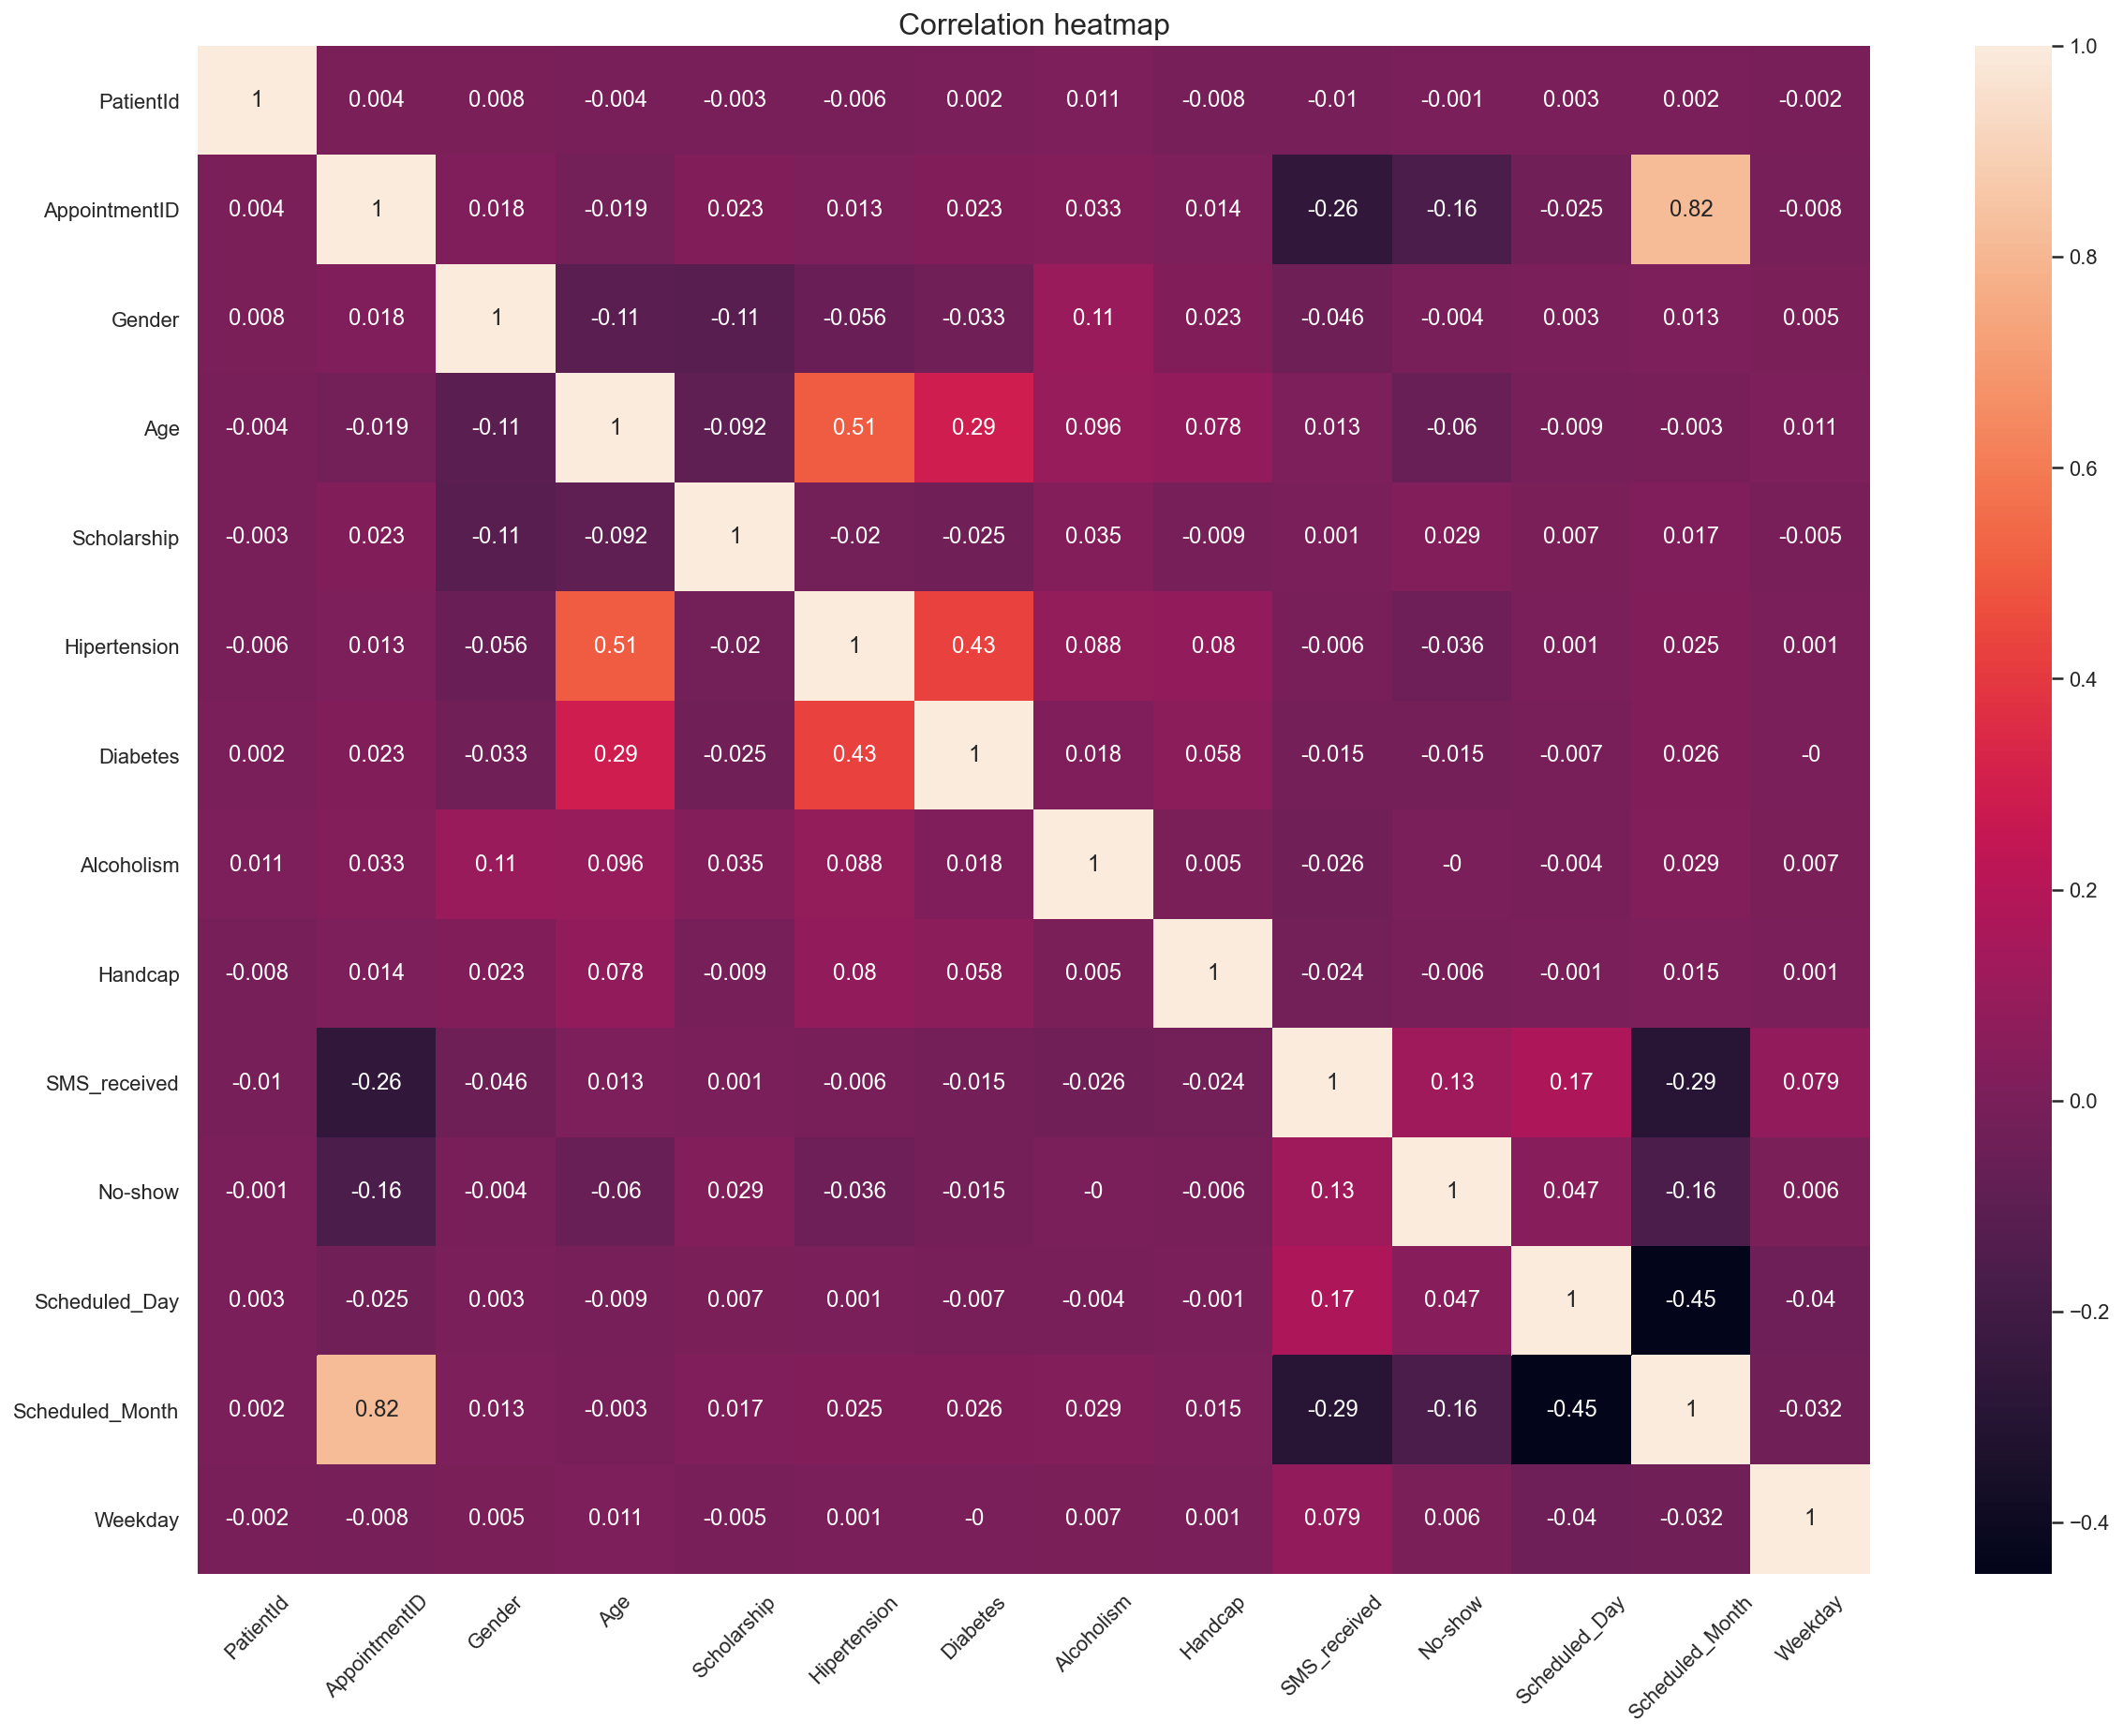

In [20]:
plt.figure(figsize=(20,15))
sns.heatmap(df_appointments.corr().round(3), annot = True)
plt.title('Correlation heatmap', size='16')
plt.xticks(rotation='45');

# UnderSampling

0    0.798067
1    0.201933
Name: No-show, dtype: float64


<AxesSubplot:>

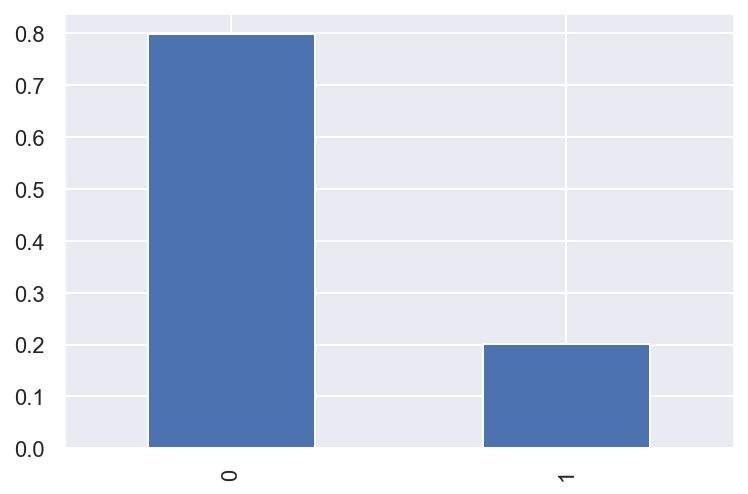

In [21]:
target_show = df_appointments['No-show'].value_counts(normalize=True) 
print(target_show)
target_show.plot(kind='bar')

In [22]:
X = df_appointments.drop(['No-show'], axis = 1)
y = df_appointments['No-show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)
X_train, X_val , y_train, y_val = train_test_split(X_train ,y_train , test_size = 0.10, random_state=42)

In [23]:
# define undersample strategy

import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.9)

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = undersample.fit_resample(X_train, y_train)

0    0.526306
1    0.473694
Name: No-show, dtype: float64


<AxesSubplot:>

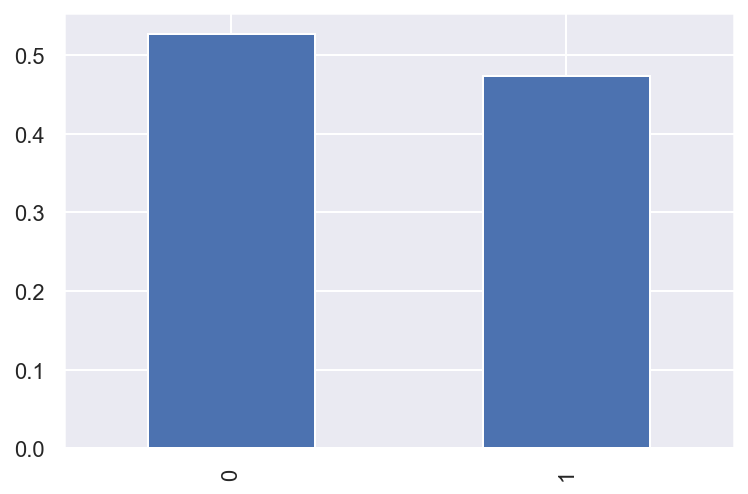

In [24]:
target_show = y_train_SMOTE.value_counts(normalize=True) 
print(target_show)
target_show.plot(kind='bar')

# Feature Engineering

In [25]:
df_appointments['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_appointments['NeighbourhoodCount'] = le.fit_transform(df_appointments['Neighbourhood'])

In [27]:
df_appointments['Time'] = df_appointments.loc[:].ScheduledDay.map(
  lambda x: str.split(x, "T")[1])

In [28]:
df_appointments['Time']=df_appointments.loc[:].Time.map(
  lambda x: str.split(x, ":")[0])

In [29]:
df_appointments['Time']=df_appointments['Time'].astype('int') 

In [30]:
df_appointments['Moring'] = (df_appointments['Time']>=0) & (df_appointments['Time']<12)

In [31]:
df_appointments['Moring'] = df_appointments['Moring'].replace(False, 0)
df_appointments['Moring'] = df_appointments['Moring'].replace(True, 1)

In [32]:
from datetime import date

df_appointments['ScheduledDay'] = pd.to_datetime(df_appointments['ScheduledDay'])
df_appointments['AppointmentDay'] = pd.to_datetime(df_appointments['AppointmentDay'])

df_appointments['days'] = abs(df_appointments['AppointmentDay'] -(df_appointments['ScheduledDay'] ))

# convert delta date to int
df_appointments['days'] = (df_appointments.days / np.timedelta64(1,'D')).astype(int)

In [33]:
df_appointments=df_appointments.drop(['Time'], axis = 1)
df_appointments = df_appointments.drop(['AppointmentDay'], axis = 1)
df_appointments = df_appointments.drop(['ScheduledDay'], axis = 1)

In [34]:
df_appointments= pd.get_dummies(df_appointments, drop_first=False)

In [35]:
df_appointments.shape

(110527, 98)

In [36]:
df_appointments.head()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,2.987250e+13,5642903,0,62,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.589980e+14,5642503,1,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.262960e+12,5642549,0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.679510e+11,5642828,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.841190e+12,5642494,0,56,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Split Data

In [37]:
X = df_appointments.drop(['PatientId','AppointmentID','Alcoholism','No-show','Scheduled_Month'], axis = 1)
y = df_appointments['No-show']

In [39]:
df_appointments

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,2.987250e+13,5642903,0,62,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.589980e+14,5642503,1,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.262960e+12,5642549,0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.679510e+11,5642828,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.841190e+12,5642494,0,56,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572130e+12,5651768,0,56,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
110523,3.596270e+12,5650093,0,51,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
110524,1.557660e+13,5630692,0,21,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
110525,9.213490e+13,5630323,0,38,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10, random_state=42)

# StandardScaler

In [43]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
lm.fit(X_train_scaled, y_train)


y_predict = lm.predict(X_train_scaled) 
lm.score(X_train_scaled, y_train)

0.7952228723083419

# Modules and Grid Search CV


## Logistic Regression

In [45]:
dt_range = list(range(1, 100))
param_grid = dict(C=dt_range)

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_SMOTE, y_train_SMOTE)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


'\nlog_reg = LogisticRegression()\ngrid = GridSearchCV(log_reg, param_grid, cv=5, scoring=\'accuracy\')\ngrid.fit(X_train_SMOTE, y_train_SMOTE)\n\nprint("Best params: ", grid.best_params_)\nprint("Best estimator: ", grid.best_estimator_)\nprint("Best score: ", grid.best_score_)\n'

In [46]:
log_reg = LogisticRegression(C=1 ,random_state=42)
log_reg.fit(X_train_scaled, y_train)
print("The score for logistic regression")
print("Training set is : {:6.2f}%".format(100*log_reg.score(X_train_scaled, y_train)))
print("validation set is: {:6.2f}%".format(100*log_reg.score(X_val_scaled, y_val)))

The score for logistic regression
Training set is :  79.52%
validation set is:  79.65%


## K Neighbors Classifier (55-Neighbors)

In [47]:

knn =KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled1, subset_y_train)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


'\nknn =KNeighborsClassifier()\ngrid = GridSearchCV(knn, param_grid, cv=5, scoring=\'accuracy\')\ngrid.fit(X_train_scaled1, subset_y_train)\n\nprint("Best params: ", grid.best_params_)\nprint("Best estimator: ", grid.best_estimator_)\nprint("Best score: ", grid.best_score_)\n'

In [48]:
knn = KNeighborsClassifier(n_neighbors=55, weights='distance')
knn.fit(X_train_scaled, y_train)
print("The score for kNN is")
print("Training set: {:6.2f}%".format(100*knn.score(X_train_scaled, y_train)))
print("validation set: {:6.2f}%".format(100*knn.score(X_val_scaled, y_val)))

The score for kNN is
Training set:  99.36%
validation set:  80.25%


## Decision Tree Classifier

In [ ]:

decisiontree = DecisionTreeClassifier()
dt_range = list(range(1, 31))
param_grid = dict(max_depth=dt_range)
grid = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_SMOTE, y_train_SMOTE)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


In [49]:
decisiontree = DecisionTreeClassifier(max_depth=21)
decisiontree.fit(X_train_scaled, y_train)
print("The score for decision tree ")
print("Training set is : {:6.2f}%".format(100*decisiontree.score(X_train_scaled, y_train)))
print("validation set is: {:6.2f}%".format(100*decisiontree.score(X_val_scaled, y_val)))

The score for decision tree 
Training set is :  86.78%
validation set is:  77.73%


## Random Forest Classifier

In [ ]:
rd_range = list(range(1, 200, 10))
param_grid = dict(n_estimators=rd_range)

randomforest = RandomForestClassifier()
grid = GridSearchCV(randomforest, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_SMOTE ,y_train_SMOTE)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


In [50]:
randomforest = RandomForestClassifier(n_estimators=161)
randomforest.fit(X_train_scaled, y_train)
print("The score for random forest ")
print("Training set is : {:6.2f}%".format(100*randomforest.score(X_train_scaled, y_train)))
print("validation set is: {:6.2f}%".format(100*randomforest.score(X_val_scaled, y_val)))

The score for random forest 
Training set is :  99.29%
validation set is:  79.20%


## Extra Trees Classifier

In [ ]:

et = ExtraTreesClassifier()
k_range = list(range(1, 100))
param_grid = dict(n_estimators=k_range)
grid1 = GridSearchCV(et, param_grid, cv=10, scoring='accuracy')
grid1.fit(X_train_SMOTE, y_train_SMOTE);


In [225]:
et = ensemble.ExtraTreesClassifier(n_estimators=77, random_state=1) 
et.fit(X_train_scaled, y_train)
print("The score for random forest ")
print("Training set is : {:6.2f}%".format(100*et.score(X_train_scaled, y_train)))
print("validation set is: {:6.2f}%".format(100*et.score(X_val_scaled, y_val)))

The score for random forest 
Training set is :  99.29%
validation set is:  78.04%


## XGBClassifier

In [228]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=900,
                        max_depth=9,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=1,
                        colsample_bytree=.8
    
                       )
                       
gbm.fit(X_train_scaled, y_train)
print("The score for XGB classifier")
print("Training set is : {:6.2f}%".format(100*gbm.score(X_train_scaled, y_train)))
print("validation set is: {:6.2f}%".format(100*gbm.score(X_val_scaled, y_val)))

The score for XGB classifier
Training set is :  87.33%
validation set is:  80.25%


## Polynomial degree=2

In [226]:
X_data = pd.concat([X_train, X_val])
y_data = pd.concat([y_train, y_val])

In [227]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=161)
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X_data)
rf.fit(X_poly,y_data)
X_test_poly = poly.transform(X_test)
y_pred = rf.predict(X_test_poly)


print("The score for random forest ploy 2 ")
print("Training set is : {:6.2f}%".format(100*rf.score(X_poly, y_data)))
print("Testing set is : {:6.2f}%".format(100*accuracy_score(y_test, y_pred)))

The score for random forest ploy 2 
Training set is :  99.20%
Testing set is :  99.09%
confusion matrix: 

 [[8815   13]
 [  88 2137]]


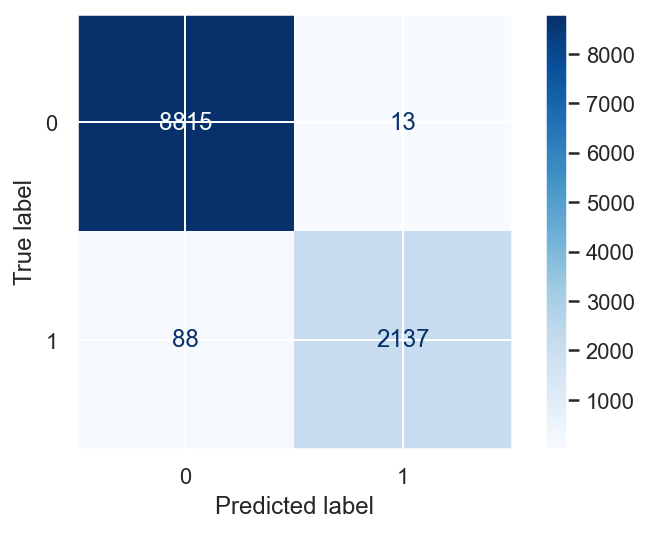

In [229]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

plot_confusion_matrix(rf, X_test_poly, y_test, cmap=plt.cm.Blues)  
plt.show()

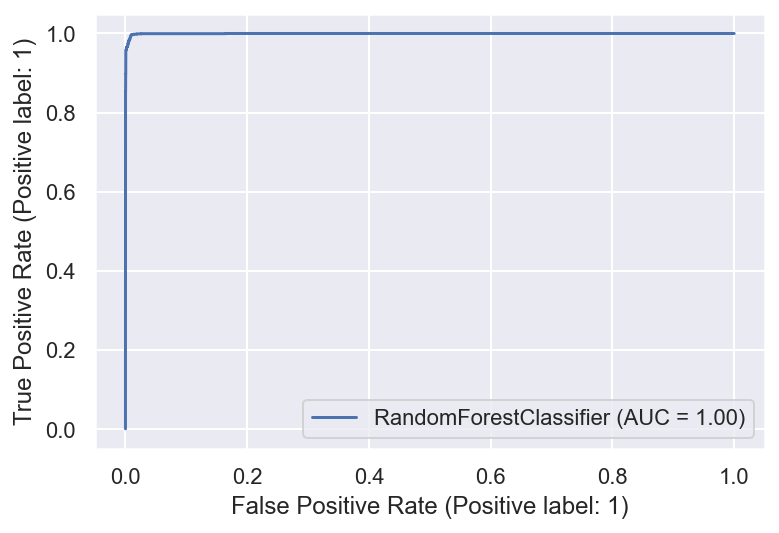

In [230]:
plot_roc_curve(rf, X_test_poly, y_test)

plt.savefig('RF_roc.png',dpi=100, bbox_inches='tight')

# Test best moduls and Standard classification metric
best model is K Neighbors Classifier (55-Neighbors)

In [243]:
print("Testing set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

Testing set:  79.86%


In [242]:
accuracies = []
precisions = []
recalls = []
roc_scores = []
f1_scores = []

print(f' Score of train set: {round(knn.score(X_train_scaled, y_train), 5)}')
print(f' Score of validation set: {round(knn.score(X_val_scaled, y_val), 5)}')
print(f' Score of test set: {round(knn.score(X_test, y_test), 5)}')
print(f' Accuracy: {round(accuracy_score(y_test, knn.predict(X_test)), 5)}')
print(f' Precision: {round(precision_score(y_test, knn.predict(X_test)), 5)}')
print(f' Recall: {round(recall_score(y_test, knn.predict(X_test)), 5)}')
print(f' F1_Score: {round(f1_score(y_test, knn.predict(X_test)), 5)}\n\n')
    

accuracies.append(round(accuracy_score(y_test, knn.predict(X_test)),5))
f1_scores.append(round(f1_score(y_test, knn.predict(X_test)),5))
precisions.append(round(precision_score(y_test, knn.predict(X_test)),5))
recalls.append(round(recall_score(y_test, knn.predict(X_test)),5))
roc_scores.append(round(roc_auc_score(y_test, knn.predict(X_test)),5))

 Score of train set: 0.99358
 Score of validation set: 0.8025
 Score of test set: 0.79861
 Accuracy: 0.79861
 Precision: 0.33333
 Recall: 0.00045
 F1_Score: 0.0009


